In [ ]:
from PyMacroFin.model import macro_model
import numpy as np
import pandas as pd
import time
import PyMacroFin.utilities as util
from PyMacroFin.system import system

# initial guess function for endogenous variables
def init_fcn(e,c):
    if e<.3:
            q = 1.05+.06/.3*e
            psi = 1/.3*e
            sigq = -.1*(e-.3)**2+.008
    else:
            psi = 1
            sigq = 0
            q = 1.1 - .03/.7*e
    return [q,psi]

# boundary condition function for eta == 0
def eta_minimum(d):
    psi = 0
    q = (2*d['ah']*d['kappa']+(d['kappa']*d['r'])**2.+1)**0.5 - d['kappa']*d['r']
    return [q,psi]


def define_model(npoints):
    m = macro_model(name='BruSan14_log_utility')

    m.set_endog(['q','psi'],init=[1.05,0.5])
    m.prices = ['q']
    m.set_state(['e'])

    m.params.add_parameter('sig',.1)
    m.params.add_parameter('deltae',.05)
    m.params.add_parameter('deltah',.05)
    m.params.add_parameter('rho',.06)
    m.params.add_parameter('r',.05)
    m.params.add_parameter('ae',.11)
    m.params.add_parameter('ah',.07)
    m.params.add_parameter('kappa',2)

    m.equation('iota = (q**2-1)/(2*kappa)')
    m.equation('phi = 1/kappa*((1+2*kappa*iota)**0.5-1)')
    m.equation('sigq = (((ae-ah)/q+deltah-deltae)/(psi/e-(1-psi)/(1-e)))**0.5 - sig',plot=True,latex=r'$\sigma^q$')
    m.equation('sige = (psi-e)/e*(sig+sigq)')
    m.equation('mue = sige**2 + (ae-iota)/q + (1-psi)*(deltah-deltae)-rho')
    m.equation('er = psi/e*(sig+sigq)**2',plot=True,latex=r'$E[dr_t^k-dr_t]/dt$')
    m.equation('sigee = sige*e',plot=True,latex=r'$\sigma^{\eta} \eta$')
    m.equation('muee = mue*e',plot=True,latex=r'$\mu^{\eta} \eta$')

    m.endog_equation('q*(r*(1-e)+rho*e) - psi*ae - (1-psi)*ah + iota')
    m.endog_equation('(psi-e)*d(q,e) - q*(1-sig/(sig+sigq))')

    # consider the value function r(x)F(x,t)= u(x) +mu(x)F_x+sig(x)^2/2 F_xx + F_t
    m.hjb_equation('mu','e','mue') # this sets mu(x) associated to e, using mue
    m.hjb_equation('sig','e','sige') # this sets sig(x) associated to e, using sige

    m.constraint('psi','<=',1,label='upper_psi')
    m.constraint('psi','>=',0,label='lower_psi')

    m.boundary_condition({'e':'min'},eta_minimum)

    s = system(['upper_psi'],m)
    s.equation('sigq = sig/(1-(psi-e)*d(q,e)/q) - sig')
    s.endog_equation('1 - psi')
    s.endog_equation('q*(r*(1-e)+rho*e) - ae + iota')

    m.systems.append(s)

    m.options.ignore_HJB_loop = True # it seems that the HJB iteration is not used
    m.options.import_guess = False
    m.options.guess_function = init_fcn
    m.options.inner_plot = False
    m.options.outer_plot = False
    m.options.final_plot = True
    m.options.n0 = npoints
    m.options.start0 = 0.0
    m.options.end0 = 0.95
    m.options.inner_solver = 'least_squares'
    m.options.derivative_plotting = [('q','e')]
    m.options.min_iter_outer_static = 5
    m.options.min_iter_inner_static = 0
    m.options.max_iter_outer_static = 50
    m.options.return_solution = True
    m.options.save_solution = False
    m.options.price_derivative_method = 'backward'

    return m

npoints = 100
tic = time.time()
m = define_model(npoints)
df = m.run()
toc = time.time()
print('elapsed time: {}'.format(toc-tic))

![result_plot](./pymacrofinsol.png)

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deepMacroFin import PDEModel
from deepMacroFin import ActivationType, Comparator, Constraint, EndogVar, EndogVarConditions, EndogEquation, System

In [2]:
# try to fit the initial guess
pde_model = PDEModel("BruSan14_log_utility", {"num_epochs": 5000})
pde_model.set_state(["e"], {"e": [0., 1.]})
pde_model.add_endogs(["q", "psi"])
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "ae": .11,
    "ah": .07,
    "kappa": 2,
})
sys1 = System([Constraint("e", Comparator.LT, "0.3", label="smaller")], "sys1")
sys1.add_endog_equation("q=1.05+.06/.3*e")
sys1.add_endog_equation("psi = 1/.3*e")
sys2 = System([Constraint("e", Comparator.GEQ, "0.3", label="smaller")], "sys2")
sys2.add_endog_equation("q=1.1 - .03/.7*e")
sys2.add_endog_equation("psi = 1")
pde_model.add_system(sys1)
pde_model.add_system(sys2)

print(pde_model)
if not os.path.exists("./models/pymacrofin_1d_init.pt"):
    pde_model.train_model("./models", "pymacrofin_1d_init.pt", True)
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/pymacrofin_1d_init.pt"))
    pde_model.eval_model(True)

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 100,
 "num_epochs": 5000,
 "lr": 0.001
}
Latex Variable Mapping:
{}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "ae": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Variables=================================
e: [0.0, 1.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: q
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=1, out_features=30, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=30, out_features=30, bias=True)
    (activation_2): Tanh()
  

Total loss: 0.0001: 100%|██████████| 5000/5000 [00:59<00:00, 83.94it/s] 

training finished, total time :: 59.56310057640076
Model saved to ./models/pymacrofin_1d_init.pt
===================================Evaluating===================================
loss :: system_sys1: 0.0000,
system_sys2: 0.0000,
total_loss: 0.0000


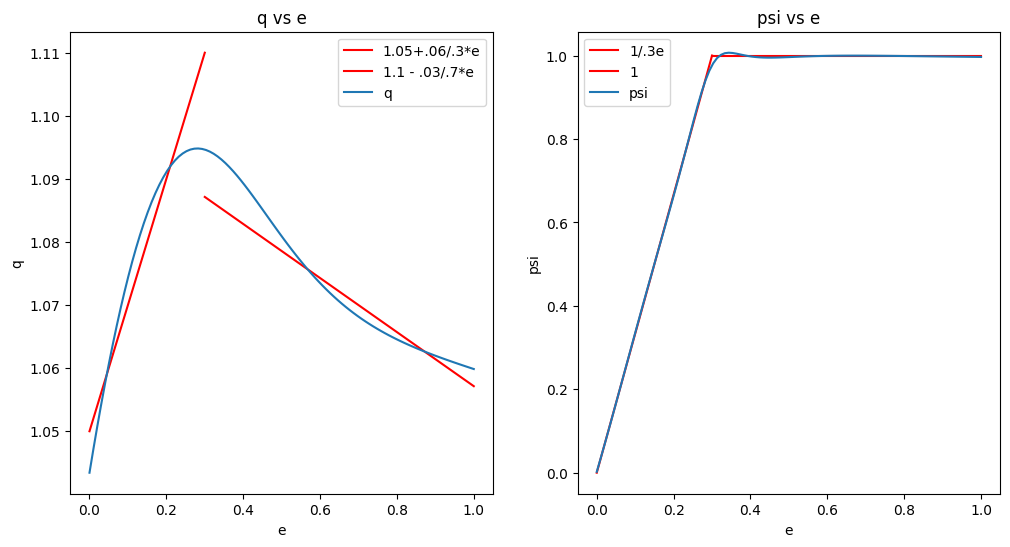

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
e = np.linspace(0, 1)
e1 = np.linspace(0, 0.3)
e2 = np.linspace(0.3, 1)
ax[0].plot(e1, 1.05+0.06/0.3*e1, label="1.05+.06/.3*e", color="red")
ax[0].plot(e2, 1.1 - .03/.7*e2, label="1.1 - .03/.7*e", color="red")
ax[1].plot(e1, 1/.3*e1, label="1/.3e", color="red")
ax[1].plot(e2, np.ones_like(e2), label="1", color="red")
# ax[2].plot(x, (-4 + 8 * x) * np.exp(-2*x), label="(-4+8x)e^{-2x}")
pde_model.endog_vars["q"].plot("q", {"e": [0, 1]}, ax=ax[0])
pde_model.endog_vars["psi"].plot("psi", {"e": [0, 1]}, ax=ax[1])
plt.subplots_adjust()
plt.show()

In [8]:
pde_model = PDEModel("BruSan14_log_utility", {"num_epochs": 100})
pde_model.set_state(["e"], {"e": [0., 1.]})
pde_model.add_endogs(["q", "psi"])
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "ae": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "(2*ah*kappa + (kappa*r)**2 + 1)**0.5 - kappa*r", pde_model.variable_val_dict,
                              label="q_min")
pde_model.add_endog_condition("psi", 
                              "psi(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "0", {},
                              label="psi_min")
pde_model.add_equation("iota = (q**2-1)/(2*kappa)")
pde_model.add_equation("phi = 1/kappa*((1+2*kappa*iota)**0.5-1)")
pde_model.add_equation("sigq = (((ae-ah)/q+deltah-deltae)/(psi/e-(1-psi)/(1-e)))**0.5 - sig")
pde_model.add_equation("sige = (psi-e)/e*(sig+sigq)")
pde_model.add_equation("mue = sige**2 + (ae-iota)/q + (1-psi)*(deltah-deltae)-rho")
pde_model.add_equation("er = psi/e*(sig+sigq)**2")
pde_model.add_equation("sigee = sige*e")
pde_model.add_equation("muee = mue*e")
pde_model.add_endog_equation("q*(r*(1-e)+rho*e) - psi*ae - (1-psi)*ah + iota=0")
pde_model.add_endog_equation("(psi-e)*q_e - q*(1-sig/(sig+sigq))=0")
pde_model.add_constraint("psi", Comparator.GEQ, "0")
pde_model.add_constraint("psi", Comparator.LEQ, "1")

sys = System([Constraint("psi", Comparator.LEQ, "1", "upper_const")], "upper_const_sys")
sys.add_equation("sigq = sig/(1-(psi-e)*q_e/q) - sig")
sys.add_endog_equation("1-psi=0")
sys.add_endog_equation("q*(r*(1-e)+rho*e) - ae + iota=0")
pde_model.add_system(sys)

print(pde_model)
if not os.path.exists("./models/pymacrofin_1d.pt"):
    pde_model.load_model(torch.load("./models/pymacrofin_1d_init.pt"))
    pde_model.train_model("./models", "pymacrofin_1d.pt", True)
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/pymacrofin_1d.pt"))
    pde_model.eval_model(True)

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 100,
 "num_epochs": 100,
 "lr": 0.001
}
Latex Variable Mapping:
{}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "ae": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Variables=================================
e: [0.0, 1.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: q
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=1, out_features=30, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=30, out_features=30, bias=True)
    (activation_2): Tanh()
   

  0%|          | 0/100 [00:00<?, ?it/s]

Total loss: 0.1325: 100%|██████████| 100/100 [00:01<00:00, 79.99it/s]

training finished, total time :: 1.257688283920288
Model saved to ./models/pymacrofin_1d.pt
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0000,
endogvar_psi_cond_psi_min: 0.0745,
endogeq_1: 0.0027,
endogeq_2: 0.0001,
constraint_1: 0.0000,
constraint_2: 0.0023,
system_upper_const_sys: 0.0372,
total_loss: 0.1169


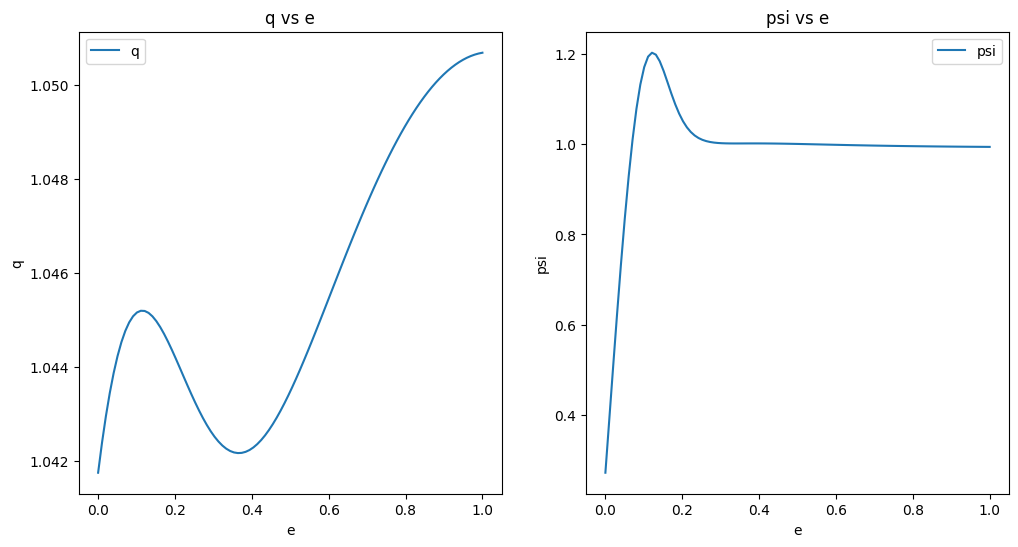

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
e = np.linspace(0, 1)
# ax[0].plot(x, (1 + 2 * x) * np.exp(-2*x), label="(1+2x)e^{-2x}")
# ax[1].plot(x, -4 * x * np.exp(-2*x), label="-4xe^{-2x}")
# ax[2].plot(x, (-4 + 8 * x) * np.exp(-2*x), label="(-4+8x)e^{-2x}")
pde_model.endog_vars["q"].plot("q", {"e": [0, 1]}, ax=ax[0])
pde_model.endog_vars["psi"].plot("psi", {"e": [0, 1]}, ax=ax[1])
plt.subplots_adjust()
plt.show()